### Purpose: To obtain object statistics from impages imported by user

*To do List:*
4. Extract Basic Statistics:
Euler number
Image Centroids
On Both Object Areas and distances from object centroids to the image centroid
Min 
Max
Mean
Median
Variance
10-bin histogram 

*Decided to do a global threshold and a local threshold * - do more research into the difference between these two things

*Step 1: Import the necessary packages*

In [10]:
import sys
sys.path.append('/Users/HawleyHelm/Desktop/CHE_545_546/Rockstar-Lifestyle')

In [86]:
from PIL import Image, ImageFilter, ImageEnhance
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import scipy
from scipy.ndimage import gaussian_filter
from skimage import filters
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage import measure
from skimage import morphology
from scipy import ndimage
from skimage import segmentation
from skimage import data, feature
import math

from RockstarLifestyle import preprocessing
from RockstarLifestyle import ObjectStats

*Step 2: User controlled inputs*

In [12]:
im_contrast_value = 2

*Step 3: Image Import*

In [13]:
im =  Image.open("Test_Photo_fromMike.png")

*Step 4: Splitting image into red, green, blue values*

In [14]:
r,g,b = im.split()

In [54]:
contrast_image = preprocessing.image_contrast(b, 2)

__Step 4: Otsu Global Threshold*__ 

In [55]:
contrast_image_arr = np.array(contrast_image)

In [56]:
thresh = filters.threshold_otsu(contrast_image_arr)
thresh

117

*Step 5: Obtaining the Binary Mask of the image*

In [57]:
binary = contrast_image_arr > thresh

*Step 6: Finding the eight connection items in the binary mask*

__Step 4: Local Threshold__

Question for me: how do you figure out what block size to use in local thresholding? - seems like i could easily introduce bias here

In [58]:
block_size = 15
adaptive_thresh = filters.threshold_local(contrast_image_arr, block_size, offset=8)
binary_adaptive = contrast_image_arr < adaptive_thresh

*Step 5: Find all eight connection items in the binary mask*

In [59]:
distance = ndimage.distance_transform_edt(binary)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)), labels=binary)

In [60]:
markers = morphology.label(local_maxi)
markers[~binary] = -1

In [61]:
labels_rw = segmentation.random_walker(binary, markers)

*Step 5: Object labeling with local Threshold*

In [62]:
distance = ndimage.distance_transform_edt(binary_adaptive)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)), labels=binary_adaptive)

In [63]:
markers = morphology.label(local_maxi)
markers[~binary_adaptive] = -1

In [64]:
labels_rw_adaptive = segmentation.random_walker(binary_adaptive, markers)

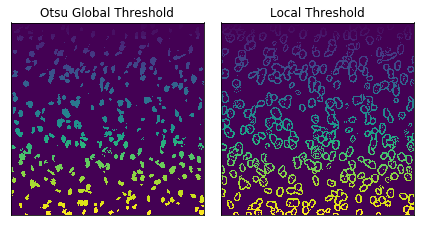

In [65]:
fig = plt.figure()
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

ax1.imshow(labels_rw) 
ax1.set_title('Otsu Global Threshold')
ax1.set_xticks([])
ax1.set_yticks([])

ax2.imshow(labels_rw_adaptive)
ax2.set_title('Local Threshold')
ax2.set_xticks([])
ax2.set_yticks([])

fig.tight_layout()

*Step 6: Extract Basic Statistics*

In [66]:
properties = measure.regionprops(labels_rw)

properties_adaptive = measure.regionprops(labels_rw_adaptive)

*Step 6a: Object Areas*

In [67]:
areas_rw = [prop.bbox_area for prop in properties]

In [68]:
areas_rw_adaptive = [prop.bbox_area for prop in properties]

*Step 6a: 10-bin histogram: Object Areas*

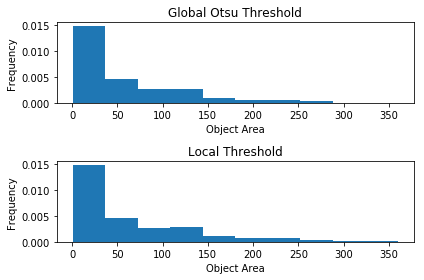

In [69]:
fig = plt.figure()
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

ax1.hist(areas_rw, bins=10, density = True, cumulative = False)
ax1.set_title('Global Otsu Threshold')
ax1.set_ylabel('Frequency')
ax1.set_xlabel('Object Area')

ax2.hist(areas_rw_adaptive, bins=10, density = True, cumulative = False)
ax2.set_title('Local Threshold')
ax2.set_ylabel('Frequency')
ax2.set_xlabel('Object Area')

fig.tight_layout()

*Step 6b: Finding Image Centroid*

In [79]:
image_centroid = properties[0].centroid
image_centroid_adaptive = properties_adaptive[0].centroid

(1.0, 33.0)

*Step 6c: Finding Object Centroids*

In [77]:
object_centroids = feature.blob_log(binary)
object_centroids

array([[511.        , 511.        ,  11.88888889],
       [511.        , 492.        ,   1.        ],
       [511.        , 366.        ,   6.44444444],
       ...,
       [  0.        , 273.        ,   1.        ],
       [  0.        , 201.        ,   6.44444444],
       [  0.        ,   0.        ,   6.44444444]])

In [76]:
object_centroids_adaptive = feature.blob_log(binary_adaptive)
object_centroids_adaptive

array([[511.        , 417.        ,   6.44444444],
       [511.        , 367.        ,  11.88888889],
       [511.        , 304.        ,   6.44444444],
       ...,
       [  0.        ,  38.        ,   1.        ],
       [  0.        ,  32.        ,   1.        ],
       [  0.        ,   3.        ,   1.        ]])

*Step 6d: Distances from Object Centroids to the Image Centroids*

In [92]:
def centroid_distance(image_centroid, object_centroid, row):
    X1 = image_centroid[0]
    Y1 = image_centroid[1]
    X2 = object_centroids[row][0]
    Y2 = object_centroids[row][1]
    distance = math.sqrt((X1-X2)**2+(Y1-Y2)**2)
    return distance

In [100]:
distances_global = []
j=0
for row in object_centroids: 
    distance = centroid_distance(image_centroid, object_centroids, j)
    distances_global.append(distance)
    j += 1

In [101]:
distances_local = []
j=0
for row in object_centroids: 
    distance = centroid_distance(image_centroid_adaptive, object_centroids_adaptive, j)
    distances_local.append(distance)
    j += 1

*Step 6c: 10-bin histogram: Centroid Distane*

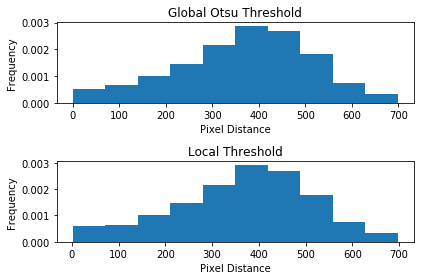

In [102]:
fig = plt.figure()
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

ax1.hist(distances_global, bins=10, density = True, cumulative = False)
ax1.set_title('Global Otsu Threshold')
ax1.set_ylabel('Frequency')
ax1.set_xlabel('Pixel Distance')

ax2.hist(distances_local, bins=10, density = True, cumulative = False)
ax2.set_title('Local Threshold')
ax2.set_ylabel('Frequency')
ax2.set_xlabel('Pixel Distance')

fig.tight_layout()

*Step 6: Number of objects*

In [105]:
object_number_global = len(object_centroids)
print('Gobal Threshold Object Number:     ', object_number_global)

Gobal Threshold Object Number:      660


In [106]:
object_number_global = len(object_centroids_adaptive)
print('Local Threshold Object Number:     ', object_number_local)

NameError: name 'object_number_local' is not defined

*Step 6b: Min, Max, Mean, Median, Variance*

*Step 7: Obtaining Euler Number*

*Step 8: Obtaining Image Centroids*